<a href="https://colab.research.google.com/github/Samuel-CHLam/activation_sparsity/blob/master/Deep_Learning_Simulation_WeekF06_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
from scipy.stats import norm, multivariate_normal
from tqdm import tqdm

# Week Michaelmas 06 - Exploring the length and correlation map
In this week, we would like to explore the length and correlation maps for deep neural network with soft thresholding activation. Recall that a soft-thresholding activation with parameter $\tau > 0$ takes the form
$$\phi(z) = \phi^{\mathsf{soft}}_\tau(z) = \mathsf{sgn}(z) (z-\tau)_+ = (z-\tau)_{+} - (-z-\tau)_{+},$$
where $z_+ = \max(z,0)$.

In [3]:
# You may wish to set the defaul tau here.
tau = 1

In [4]:
def soft_thresholding(x, tau=tau):
  return K.relu(x - tau) - K.relu(-x - tau)

def soft_thresholding_numpy(x, tau=tau):
  return np.maximum(x-tau, 0) - np.maximum(-x-tau, 0)

get_custom_objects().update({'custom_activation': Activation(soft_thresholding)})

# Part 1. Observing the length map
The length map is given by
$$V_\phi(q) = \sigma^2_w \int_\mathbb{R} (\phi(\sqrt{q} z))^2 \gamma(dz) + \sigma^2_b.$$

There are three ways to observe the length map, and compute the equilibrium points:
- By numerically compute the integral
- By analytically compute the integral (in terms of the CDF of a normal density).
- By iterating over a neural network.

**Task.** Let us build a function which compute the length map numerically.

In [10]:
# Numerical computation
def normal(z):
  return (1/np.sqrt(2*np.pi))*np.exp(-(z**2)/2)

def integrand(z,q,tau=tau):
  return normal(z)*(soft_thresholding_numpy(np.sqrt(q)*z, tau=tau)**2)

def length_map_numerical(q,sw,sb,tau=tau):
  inter_q, _ = sp.integrate.quad(lambda z: integrand(z, q, tau=tau), -np.inf, np.inf)
  return (sw**2)*inter_q + sb**2

**Task.** Let us build a function which compute the length map using the CDF of a standard normal. The formula is given by 
$$
\begin{aligned}
V_\phi(q) &= 2\sigma^2_w \Bigg[ q \bigg(\bigg( \frac{\tau}{\sqrt{q}} \bigg) \phi\bigg(\frac{\tau}{\sqrt{q}} \bigg) + \tilde{\Phi}\bigg(\frac{\tau}{\sqrt{q}} \bigg) \bigg) - 2\sqrt{q}\tau \phi\bigg(\frac{\tau}{\sqrt{q}}\bigg) + \tau^2 \tilde{\Phi}\bigg(\frac{\tau}{\sqrt{q}}\bigg) \Bigg] + \sigma^2_b \\
&= 2\sigma^2_w \Bigg[(q+\tau^2) \tilde{\Phi}\bigg( \frac{\tau}{\sqrt{q}} \bigg) - \sqrt{q}\tau \phi \bigg(\frac{\tau}{\sqrt{q}} \bigg) \Bigg] + \sigma^2_b
\end{aligned}$$
where $\phi$ is the normal density, $\Phi(z)$ (called as `norm.cdf`) being the standard normal CDF and and $\tilde{\Phi}(z) = 1 - \Phi(z)$ (called as `norm.sf`).

In [11]:
# Analytical computation
def length_map_analytical(q,sw,sb,tau=tau):
  ratio = tau/np.sqrt(q)
  inter_q = (q + tau**2) * norm.sf(ratio) - np.sqrt(q) * tau * normal(ratio)
  return 2*(sw**2) * inter_q + sb**2

**Task:** Let's make sure the two functions are consistent with each other. Here we choose $\sigma_w = 1$ and $\sigma_b = .3$.

[0.11313578589953746, 0.16270091806606807, 0.2360509698422781, 0.3284485799465415, 0.4362613854017755, 0.5567948095883573, 0.6880241181178467, 0.828395292793525, 0.9766899726662611, 1.1319343337700762, 1.2933366139363598, 1.4602433782731143, 1.6321082345472109, 1.808468993219086, 1.9889306792240702, 2.1731526775390875, 2.3608388568256715, 2.5517298757651314, 2.745597108801586, 2.9422378015836315, 3.1414711634688177, 3.34313517959792, 3.5470839994351815, 3.753185769921593, 3.961320827562876, 4.171380179261161, 4.383264221029877, 4.596881639931289, 4.812148486244883, 5.02898736513429, 5.247326744810132, 5.46710035136534, 5.688246647418108, 5.910708368329051, 6.134432120262438, 6.35936802317535, 6.585469396750797, 6.812692478323388, 7.040996176174231, 7.270341836530572, 7.500693081528145, 7.732015560617292, 7.964276938128564, 8.197446390118747, 8.431495058165961, 8.66639534137142, 8.902121170621733, 9.138647732922282, 9.375951449965566, 9.614009870202192, 9.852801609434676, 10.09230627032

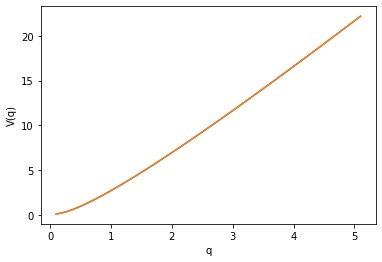

In [12]:
tau, sw, sb = 0.5, 1., 0.3
x_eval = np.linspace(0.1,5.1,100)
y_numerical = [length_map_numerical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.1,5.1,100)]
y_analytical = length_map_analytical(x_eval, sw=2.5, sb=0.3, tau=tau)
plt.plot(x_eval, y_numerical)
plt.plot(x_eval, y_analytical)
plt.xlabel("q")
plt.ylabel("V(q)")

print([length_map_numerical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.1,5.1,100)])
print([length_map_analytical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.1,5.1,100)])

**Task:** Let's try simulate various iterations of the length map.

In [14]:
def compute_q_star(sw,sb,tau=tau,N=1000,mode="analytical",seed=None,max_steps=50,show_hist=False,clip=50,err_val=-5):
  x = np.random.normal(size=N)

  # use initial condition given in the paper
  q0 = (1/len(x))*np.dot(x,x)
  q1 = (sw**2)*q0 + sb**2 

  # storing the iterates
  qs = []
  qs.append(q0)
  qs.append(q1)

  #iterate to convergence within specified tolerance
  count = 0
  while (np.abs(qs[count+1]-qs[count]) > 1e-04).any() and count <= max_steps:
    if mode == "analytical":
      q1 = length_map_analytical(q1, sw=sw, sb=sb, tau=tau)

    if mode == "numerical":
      # only support scalar output
      q1 = length_map_numerical(q1, sw=sw, sb=sb, tau=tau)

    qs.append(q1)
    count+=1

  if show_hist:
    # only support scalar output
    plt.plot(qs)
    plt.xlabel('$\ell$')
    plt.ylabel('$q^\ell$')
    print(np.array(qs))

  q_final = qs[-1]
  print(type(q_final))

  if type(q_final) == np.ndarray:
    q_final[q_final > clip] = err_val
    # q_final[q_final < -0.1] = err_val
    return q_final
  else:
    if q_final > clip:
      return err_val
    else:
      return q_final

Note that the length map does not necessary converge, and even if it converges, it might not necessary converge to a positive values.

[1.00950427 1.09950427 0.57151396 0.26528156 0.13262965 0.09834674
 0.09351598 0.09300173 0.09294949]
<class 'numpy.float64'>


0.09294949311798568

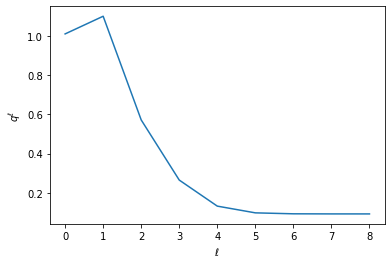

In [47]:
compute_q_star(1,.3,show_hist=True)

[0.99214947 1.99214947 2.09257938 2.1655336  2.21892423 2.25819769
 2.28719086 2.30864991 2.32456223 2.33637758 2.34515956 2.35169172
 2.35655306 2.36017242 2.36286789 2.36487575 2.36637166 2.36748629
 2.36831689 2.36893588 2.3693972  2.36974103 2.36999728 2.37018828
 2.37033064 2.37043675 2.37051584]
<class 'numpy.float64'>


2.370515840847263

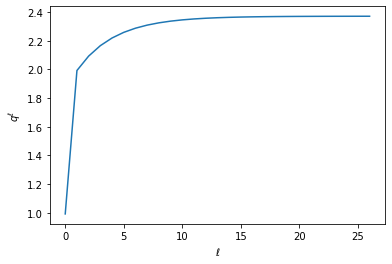

In [48]:
compute_q_star(1,1,show_hist=True)

[1.02999548e+00 1.01029995e+02 1.93256857e+02 2.82412526e+02
 3.69251991e+02 4.54168166e+02 5.37412712e+02 6.19164587e+02
 6.99559475e+02 7.78704820e+02 8.56688435e+02 9.33583824e+02
 1.00945369e+03 1.08435233e+03 1.15832738e+03 1.23142103e+03
 1.30367103e+03 1.37511138e+03 1.44577294e+03 1.51568384e+03
 1.58486992e+03 1.65335496e+03 1.72116099e+03 1.78830845e+03
 1.85481640e+03 1.92070267e+03 1.98598397e+03 2.05067599e+03
 2.11479354e+03 2.17835059e+03 2.24136037e+03 2.30383541e+03
 2.36578763e+03 2.42722835e+03 2.48816837e+03 2.54861799e+03
 2.60858706e+03 2.66808499e+03 2.72712081e+03 2.78570317e+03
 2.84384038e+03 2.90154043e+03 2.95881101e+03 3.01565950e+03
 3.07209305e+03 3.12811853e+03 3.18374258e+03 3.23897162e+03
 3.29381186e+03 3.34826930e+03 3.40234975e+03 3.45605884e+03
 3.50940203e+03]
<class 'numpy.float64'>


-5

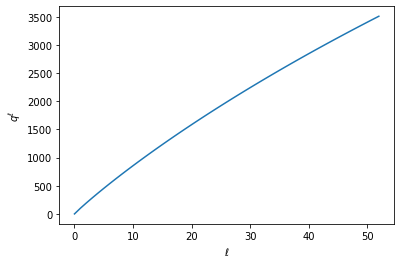

In [49]:
compute_q_star(1,10,show_hist=True)

**Task:** Let's compute the fixed points for different values of $\sigma_w$ and $\sigma_b$.

In [50]:
nx, ny = (300,300)
x = np.linspace(.1, 1.5, nx)
y = np.linspace(.1, 1.5, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
zss = compute_q_star(xv, yv, tau=0.5, max_steps=100, clip=20, err_val=-10)

# zs = np.zeros(xv.shape)
# for i in tqdm(range(nx)):
#  for j in range(ny):
#    zs[i,j] = compute_q_star(xv[i,j], yv[i,j], tau=0.5, max_steps=6, clip=5)

<class 'numpy.ndarray'>


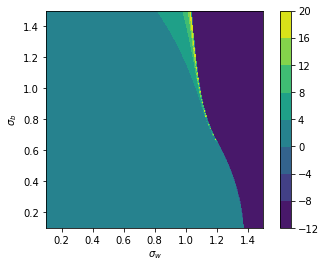

In [51]:
h = plt.contourf(x, y, zss)
plt.axis('scaled')
plt.xlabel("$\sigma_w$")
plt.ylabel("$\sigma_b$")
plt.colorbar()
plt.show()

# Part 2. Compute the edge of chaos curve.

The edge of chaos have the following formula for soft-thresholding.
$$\chi_1 = \sigma^2_w \int_\mathbb{R} \left(\phi'(\sqrt{q^*} z) \right)^2 \, \gamma(dz) = 2\sigma^2_w \tilde{\Phi}\left(\frac{\tau}{\sqrt{q^*}}\right) = 1$$

We may therefore simulate the edge of chaos by fixing $q^*$, then find $\sigma_w$ then $\sigma_b$. Again, we may compute this edge of chaos curve numerically (using Scipy integrator) or using `norm.sf`.

We note that $V'_\phi(q) = 2\sigma^2_w \tilde{\Phi}\left(\frac{\tau}{\sqrt{q}} \right)$ as well.

**Task:** Implement a function which takes in $q^*$ and compute the theoretical $\sigma_w$ and $\sigma_b$.

In [8]:
def get_sw_sb_from_q_star_numerical(qstar, tau=tau):
  def d_soft(z,tau=tau):
    return 1 - (np.abs(z) < tau)

  def chi_1_integrand(z, qstar, tau=tau):
    return normal(z)*(d_soft(np.sqrt(qstar)*z, tau=tau))**2
    
  def calc_sw(qstar, tau=tau):
    integral, _ = sp.integrate.quad(lambda z: chi_1_integrand(z,qstar,tau=tau), -np.inf, np.inf)
    return np.sqrt(np.divide(1,integral))

  def calc_sb(qstar, sw, tau=tau):
    integral, _ = sp.integrate.quad(lambda z: integrand(z,qstar,tau=tau), -np.inf, np.inf)
    return np.sqrt(qstar - (sw**2)*integral)
  
  c_sw = calc_sw(qstar)
  c_sb = calc_sb(qstar, c_sw)

  return (c_sw, c_sb)

In [17]:
def get_sw_sb_from_q_star_analytical(q, tau=tau):
  ratio = tau/np.sqrt(q)
  sw2 = 0.5/norm.sf(ratio)
  sb2 = q - 2*sw2*((q + tau**2) * norm.sf(ratio) - np.sqrt(q) * tau * normal(ratio))
  return np.sqrt(np.array([sw2, sb2]))

In [20]:
qstar_eval = np.logspace(0, 1.53, 100)

sigma_ws_numerical = []
sigma_bs_numerical = []

for qstar in tqdm(qstar_eval):
  sw, sb = get_sw_sb_from_q_star_numerical(qstar, tau=1)
  sigma_ws_numerical.append(sw)
  sigma_bs_numerical.append(sb)

 37%|███▋      | 37/100 [00:01<00:02, 23.93it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  if __name__ == '__main__':
100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


In [21]:
sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=1)
sigma_ws_analytical = sigma_ws_bs_analytical[0]
sigma_bs_analytical = sigma_ws_bs_analytical[1]

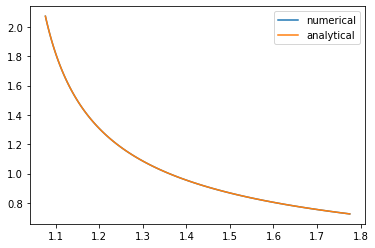

In [22]:
plt.plot(sigma_ws_numerical, sigma_bs_numerical)
plt.plot(sigma_ws_analytical, sigma_bs_analytical)
plt.legend(["numerical", "analytical"])

# Combining all analysis

<class 'numpy.ndarray'>


NameError: ignored

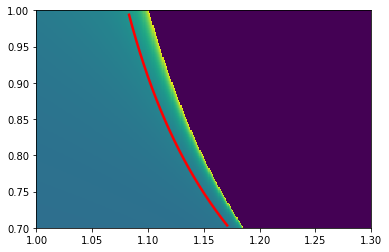

In [25]:
nx, ny = (300,300)
x = np.linspace(1.0, 1.3, nx)
y = np.linspace(0.7, 1.0, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
zss = compute_q_star(xv, yv, tau=0.5, max_steps=50, clip=20, err_val=-10)

qstar_eval = np.logspace(.32, .86, 1000)
sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval)
sigma_ws_analytical = sigma_ws_bs_analytical[0]
sigma_bs_analytical = sigma_ws_bs_analytical[1]

plt.pcolormesh(x, y, zss)
plt.plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
plt.plot(sigma_alt_ws_analytical, sigma_alt_bs_analytical, color="orange", linewidth=2.5)
plt.axis('scaled')
plt.xlabel("$\sigma_w$")
plt.ylabel("$\sigma_b$")
plt.colorbar()

# fig.subplots_adjust(right=1.2)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(im, cax=cbar_ax)
plt.show()

## Let's try running through the analysis for multiple $\tau$.

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


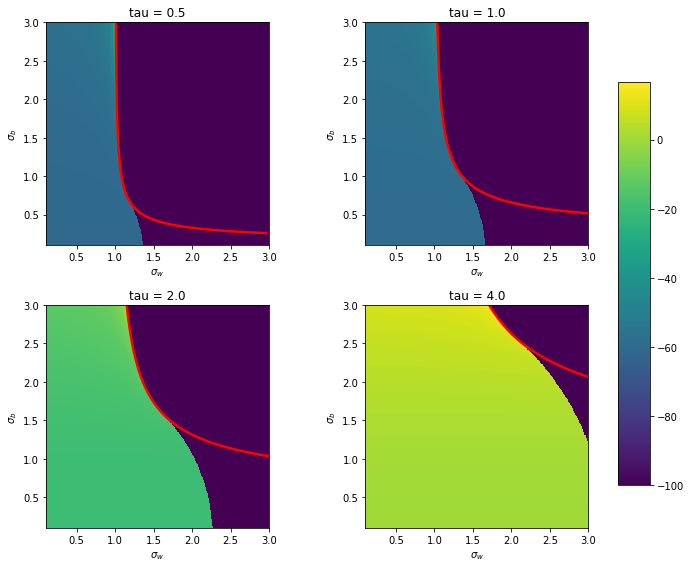

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
taus = np.array([[0.5, 1], [2,4]])
nx, ny = (400,300)
x = np.linspace(.1, 3, nx)
y = np.linspace(.1, 3, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
qstar_eval = np.logspace(-1, 4, 1000)

for i, j in [(0,0), (0,1), (1,0), (1,1)]:
  zss = compute_q_star(xv, yv, tau=taus[i][j], max_steps=300, clip=200, err_val=-100)
  sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=taus[i][j])
  sigma_ws_analytical = sigma_ws_bs_analytical[0]
  sigma_bs_analytical = sigma_ws_bs_analytical[1]
  im = ax[i][j].pcolormesh(x,y,zss)
  # fig.colorbar(im, ax=ax, shrink=0.9)
  ax[i][j].plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
  ax[i][j].axis('scaled')
  ax[i][j].set_xlim([0.1, 3])
  ax[i][j].set_ylim([0.1, 3])
  ax[i][j].set_xlabel("$\sigma_w$")
  ax[i][j].set_ylabel("$\sigma_b$")
  ax[i][j].set_title(f"tau = {taus[i][j]}")

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()  